# Microscopy

Optical microscopes use an optical system of lenses and visible light to generate a magnified image of a sample.
The maximum attainable magnification in current setups, due to physical limitations, is about 1000x.

While other microscopy techniques with higher magnification exist, our use-cases typically require that the sample, e.g., a bacterial culture, can proliferate while being observed.
This is not the case with methods like [atomic force microscopy (AFM)](https://en.wikipedia.org/wiki/Atomic_force_microscopy) and [electron microscopy](https://en.wikipedia.org/wiki/Electron_microscope).

## Typical image processing problems
In the following we assume that an image, or a sequence of images, has been obtained. Processing typically requires to:
- detect the presence of particular objects in an image
- additionally, detect the position if the objects, e.g., via a bounding-box or at the pixel-level (segmentation)
- additionally, track the objects along the sequence of images

In this lecture, we will focus on the segmentation problem.

## Idealized Data

We will start with idealized data. We assume that objects are disk-shaped, but can potentially overlap.

In [125]:
%%capture
# In case skimage is not already installed, run:
# %pip install scikit-image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import skimage
from skimage.draw import disk

class Canvas:
    x: int
    y: int
    img: np.ndarray

    def __init__(self, x: int, y: int) -> None:
        """Creates a canvas.
        x: width
        y: length
        """
        self.x = x
        self.y = y
        self.img = np.zeros([x, y], dtype='int64')

    def disk(self, x: int, y: int, r: int) -> None:
        """Draws a disk.
        x, y: center
        r: radius
        """
        rr, cc = disk((x, y), r)
        self.img[rr, cc] = 1
    
    def show(self) -> None:
        plt.imshow(self.img, cmap='gray')


Let's draw some circles. For the sake of challenge, two of them will overlap.

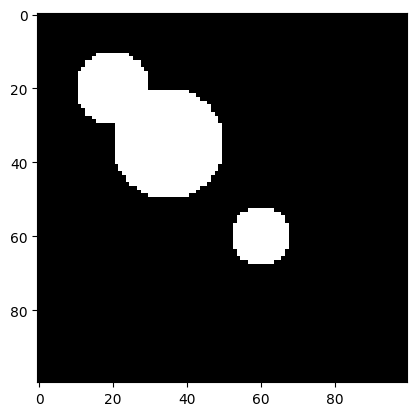

In [126]:
c = Canvas(100, 100)
c.disk(20, 20, 10)
c.disk(35, 35, 15)
c.disk(60, 60, 8)
c.show()

## A solution: Distance Maxima and Watershedding

We now aim to perform a segmentation of this image. In particular, a so-called segmentation mask has the same dimensions as the original image, with each pixel value being the id of the object it belongs to.
Typically, the value 0 is reserved for the background.
In our case, 3 more values are to be assigned, corresponding to the 3 circles.

We solve this problem via a commonly used approach:
1. Generate a distance field to the background.
2. Let the local maxima correspond to the centers of the objects.
3. Use the [watershedding](https://en.wikipedia.org/wiki/Watershed_(image_processing)) algorithm to assign the remaining pixels.

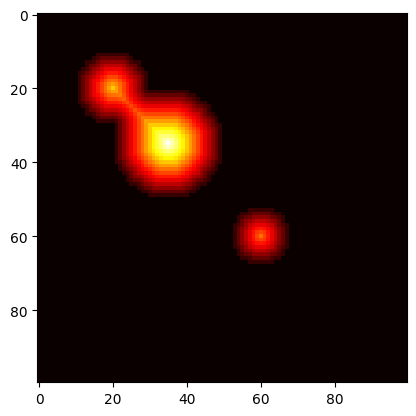

In [127]:
from scipy import ndimage as ndi

# compute distance to 0-valued background
distance = ndi.distance_transform_edt(c.img)
assert isinstance(distance, np.ndarray), "ensure type"

plt.imshow(distance, cmap=plt.cm.hot);

We next use `peak_local_max(...)` to find local maxima. The function has a parameter that specifies the locality:
- footprint : ndarray of bools, optional
        If provided, `footprint == 1` represents the local region within which
        to search for peaks at every point in `image`.

Number of cells: 3


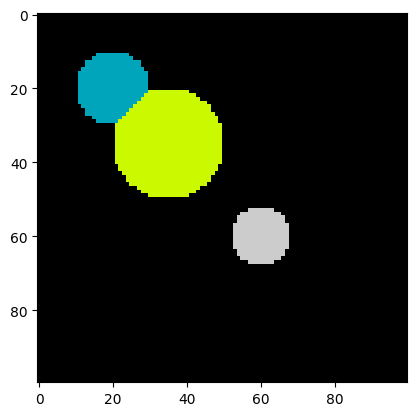

In [128]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# show local maxima (https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html)

def find_watershed(img: np.ndarray, min_distance: int=10, footprint: np.ndarray=np.ones((10,10))) -> tuple[np.ndarray, int]:
    # get distance to background (i.e., value = 0)
    distance = ndi.distance_transform_edt(img)
    assert isinstance(distance, np.ndarray), "ensure type"

    # get local (within footprint) maxima of the distance field
    # filter via minimum distance between maxima
    coords = peak_local_max(distance, labels=img, min_distance=min_distance, footprint=footprint)

    # create segmentation labels of pixels
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, num_features = ndi.label(mask)
    return watershed(-distance, markers, mask=img), num_features

labels, num_features = find_watershed(c.img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

## Noise

Let's increase the difficulty by adding some noise.

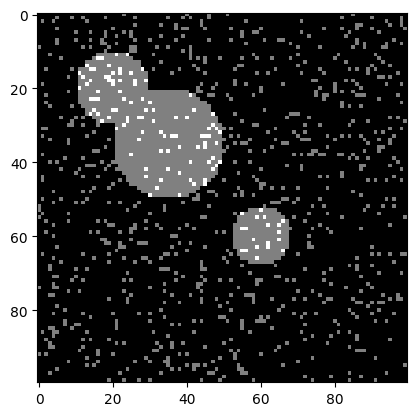

In [129]:
from numpy import dtype

img = c.img + (1.1 * np.random.random(c.img.shape)).astype("int64")
plt.imshow(img, cmap=plt.cm.gray);

And repeat the above approach.

Number of cells: 41


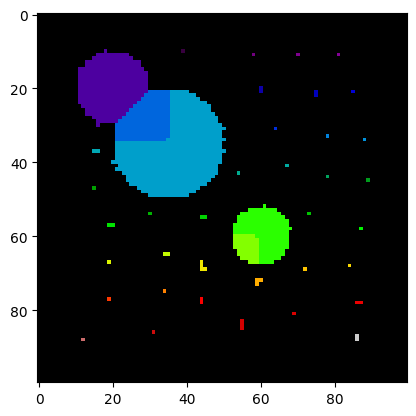

In [130]:
labels, num_features = find_watershed(img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The segmentation and the number of cells is clearly off. Let's do some preprocessing.

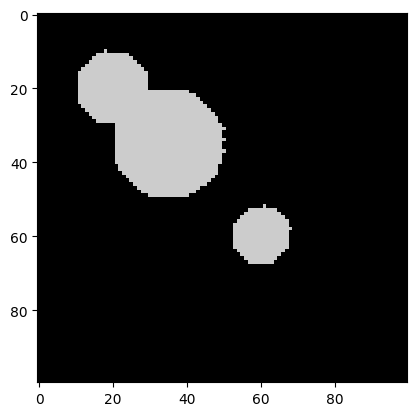

In [131]:
from scipy.ndimage import binary_erosion, binary_dilation

# shrink
img_new = binary_erosion(img, iterations=3)
# grow
img_new = binary_dilation(img_new, iterations=3)

plt.imshow(img_new, cmap=plt.cm.nipy_spectral);

Number of cells: 3


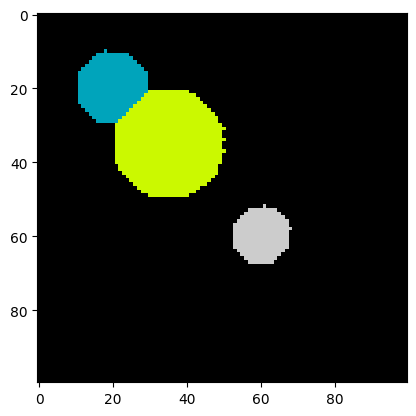

In [132]:
labels, num_features = find_watershed(img_new)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

Now the segmentation is correct. Let's move to real data next.

## Microscopic data of *E. coli*

We have uploaded an image of *E. coli* that was obtained with a microfluidic setup, an inverted microscope (40x lense), and a Raspberry Pi + camera. The image `ecoli.png` is a crop of this image showing 3 bacteria. 

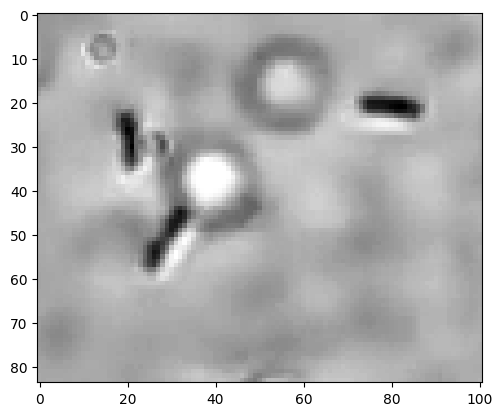

In [133]:
from skimage.color import rgb2gray

img = skimage.io.imread("ecoli.png")
img = rgb2gray(img)

plt.imshow(img, cmap=plt.cm.gray);

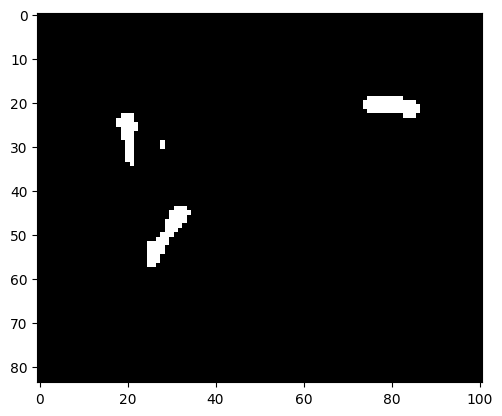

In [134]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img*255 < 180)
img_bin[mask] = 100
plt.imshow(img_bin, cmap=plt.cm.gray)

img_bin = binary_erosion(img_bin, iterations=1)
img_bin = binary_dilation(img_bin, iterations=1)

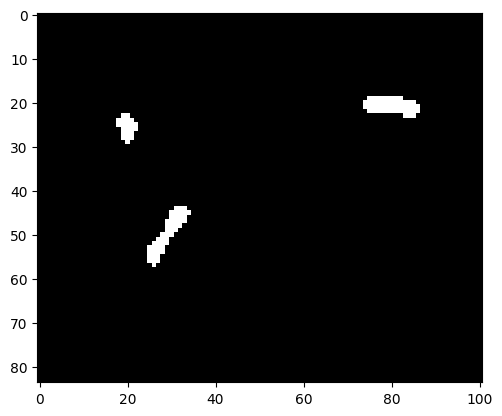

In [135]:
img_bin = binary_erosion(img_bin, iterations=1)
img_bin = binary_dilation(img_bin, iterations=1)

plt.imshow(img_bin, cmap=plt.cm.gray)

Number of cells: 3


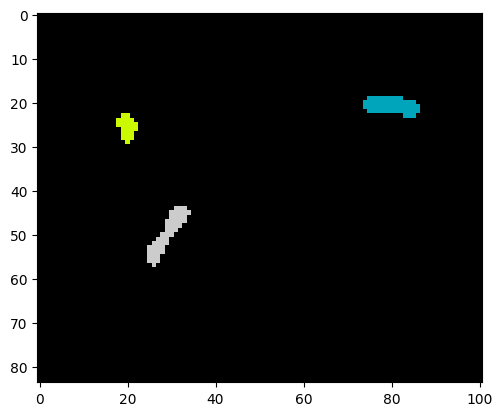

In [136]:
labels, num_features = find_watershed(img_bin, min_distance=10)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

Again, a correct segmentation was obtained.

### Challenging microscopic data

The following uses the [dataset by Scherr et al.](https://data.niaid.nih.gov/resources?id=ZENODO_6497714). Please download it and move it into the main folder.

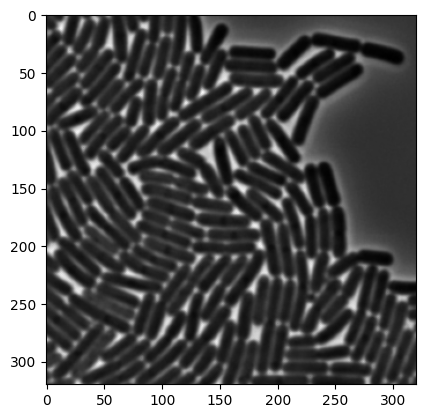

In [137]:
file_name = "microbeSEG_dataset/test/test/img_000.tif"
img = skimage.io.imread(file_name)
# normalize
img = img / np.max(img) * 255

plt.imshow(img, cmap=plt.cm.gray);

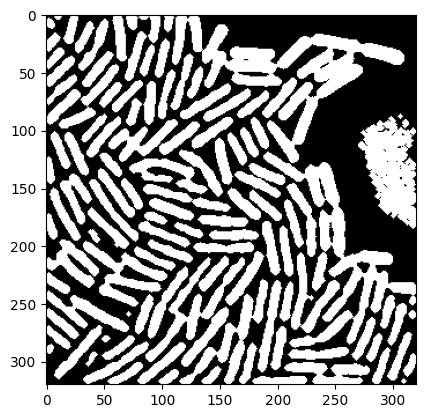

In [138]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img < 50)
img_bin[mask] = 100

img_bin = binary_erosion(img_bin, iterations=2)
img_bin = binary_dilation(img_bin, iterations=2)
plt.imshow(img_bin, cmap=plt.cm.gray);

On the right center of the image, it is already visible that some of the background has been detected as objects. You can play around with the preprocessing parameters and the threshold of `50`, but no satisfying parameters can be found.

Indeed, subsequent segmentation with watershedding yields wrong results.

Number of cells: 352


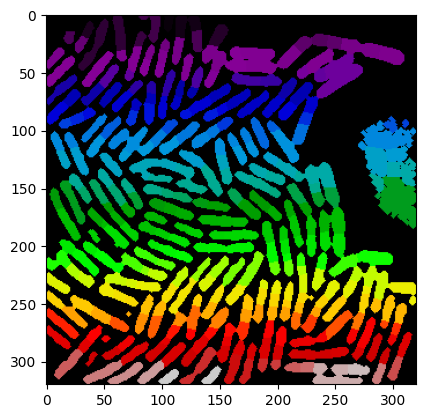

In [139]:
labels, num_features = find_watershed(img_bin, min_distance=10, footprint=np.ones([10,10]))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The number of cells has clearly been overestimated. Playing round with the parameters of `find_watershed` may slightly improve the result, but the ground truth is not (easily) obtained.

### Deep learning for segmentation

[segmentation_models](https://github.com/qubvel-org/segmentation_models.pytorch)

In [140]:
import segmentation_models_pytorch as smp

OUT_CLASSES = 1

```python
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,            # model output channels (number of classes in your dataset)
)
```

In [141]:
# adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

import os
import cv2
import re

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

DATA_DIR = "./microbeSEG_dataset/test/test/"

In [142]:
def prefix_files(dir: str, prefix: str) -> list[str]:
    pattern = prefix + r'_(\d+)'
    img_files = []
    for filename in os.listdir(dir):
        match = re.match(pattern, filename)
        if match:
            img_files.append((filename, int(match.group(1))))
    
    # sort by number
    img_files.sort(key=lambda x: x[1])
    return [os.path.join(dir, f[0]) for f in img_files]

prefix_files(DATA_DIR, "img")

['./microbeSEG_dataset/test/test/img_000.tif',
 './microbeSEG_dataset/test/test/img_001.tif',
 './microbeSEG_dataset/test/test/img_002.tif',
 './microbeSEG_dataset/test/test/img_003.tif',
 './microbeSEG_dataset/test/test/img_004.tif',
 './microbeSEG_dataset/test/test/img_005.tif',
 './microbeSEG_dataset/test/test/img_006.tif',
 './microbeSEG_dataset/test/test/img_007.tif',
 './microbeSEG_dataset/test/test/img_008.tif',
 './microbeSEG_dataset/test/test/img_009.tif',
 './microbeSEG_dataset/test/test/img_010.tif',
 './microbeSEG_dataset/test/test/img_011.tif',
 './microbeSEG_dataset/test/test/img_014.tif',
 './microbeSEG_dataset/test/test/img_015.tif',
 './microbeSEG_dataset/test/test/img_016.tif',
 './microbeSEG_dataset/test/test/img_017.tif',
 './microbeSEG_dataset/test/test/img_018.tif',
 './microbeSEG_dataset/test/test/img_019.tif',
 './microbeSEG_dataset/test/test/img_020.tif',
 './microbeSEG_dataset/test/test/img_021.tif',
 './microbeSEG_dataset/test/test/img_022.tif',
 './microbeSE

In [143]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)

    """

    CLASSES = [
        "cell",
        "background",
    ]

    def __init__(
        self,
        images_dir,
        classes=(),
        augmentation=None,
        dataset_factor: int=10,
    ):
        self.images_fps = prefix_files(images_dir, "img") * dataset_factor
        self.masks_fps = prefix_files(images_dir, "mask") * dataset_factor

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(c.lower()) for c in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], flags=2)

        # extract certain classes from mask (e.g. cells)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float32")
        # invert mask: 1 <-> segment
        mask = 1 - mask

        # apply augmentation
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)

    def __len__(self):
        return len(self.images_fps)
    

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()

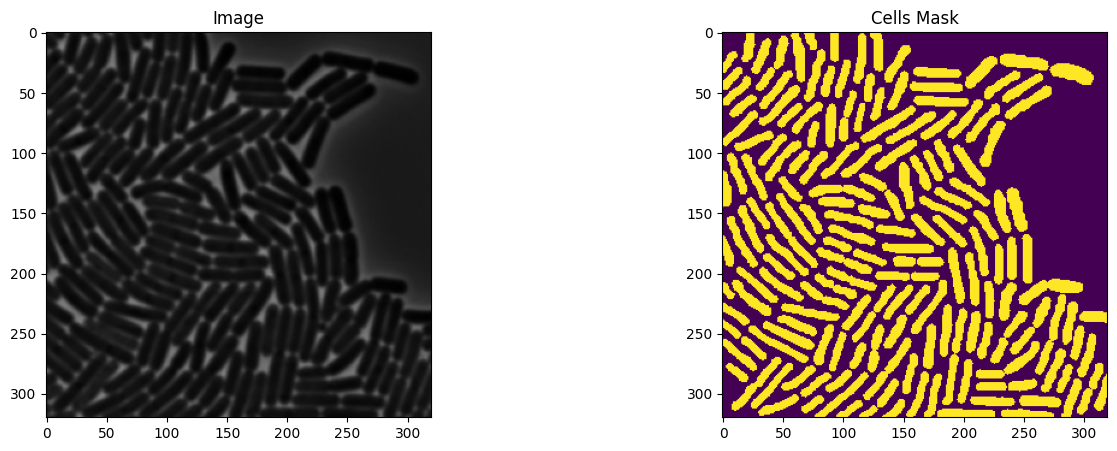

In [144]:
dataset = Dataset(DATA_DIR, classes=["cell"])

# check one of them
image, mask = dataset[0]
visualize(
    image=image,
    cells_mask=mask.squeeze(),
)

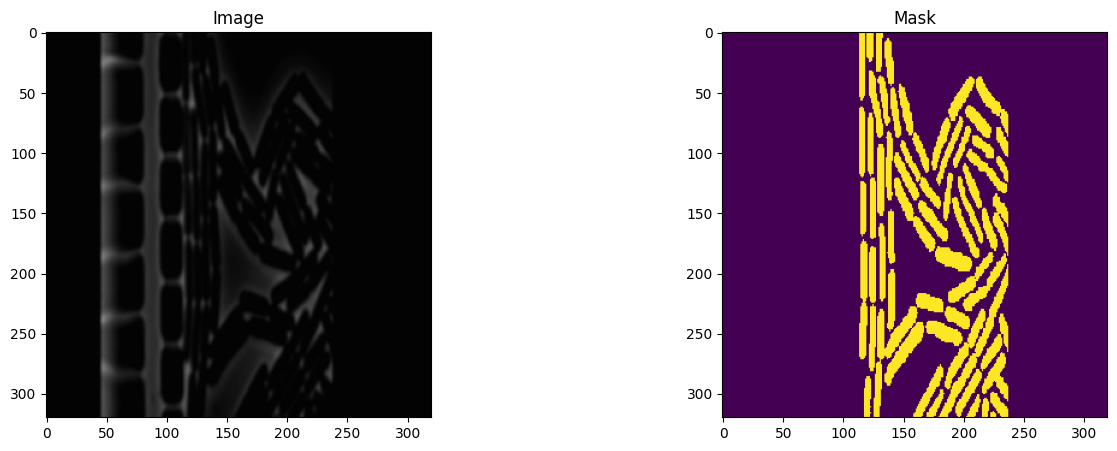

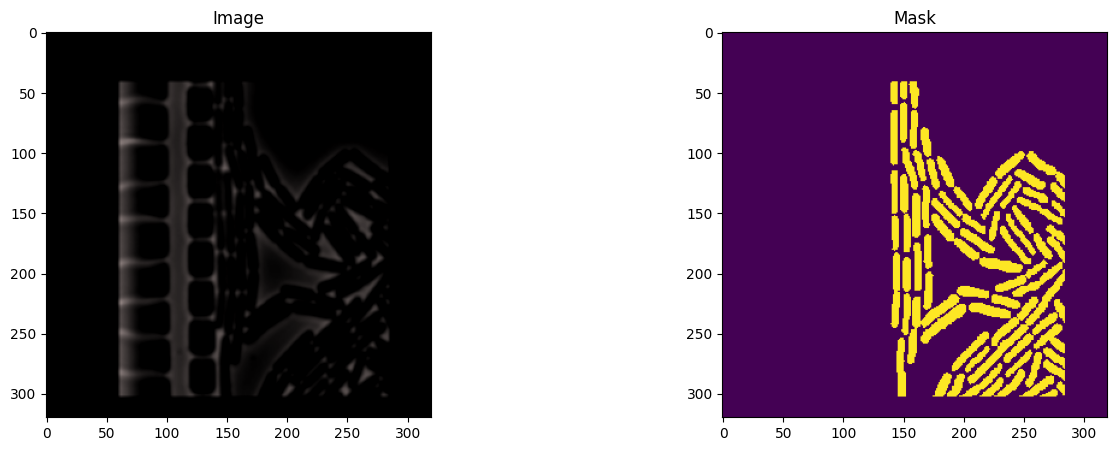

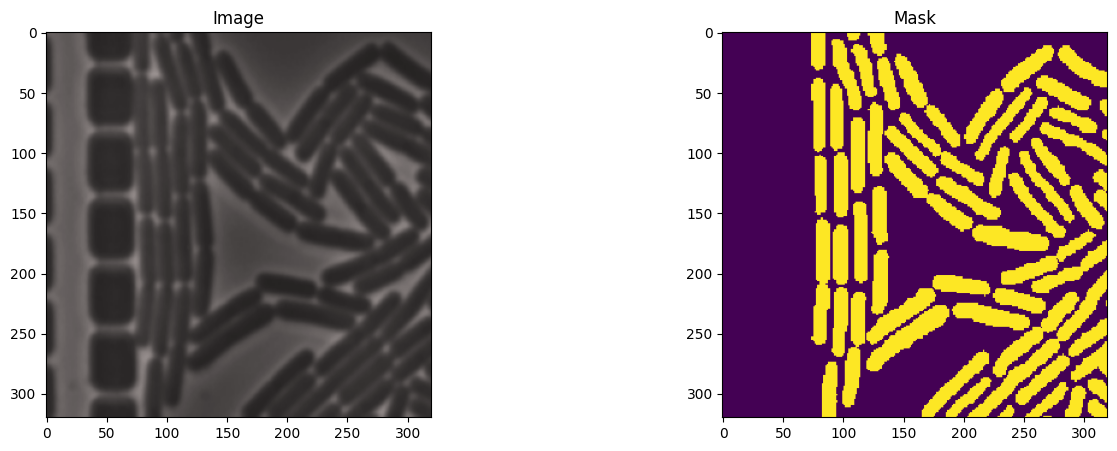

In [145]:
# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        A.RandomCrop(height=320, width=320, always_apply=True),
        A.GaussNoise(p=0.01),
        # A.Perspective(p=0.1),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480),
    ]
    return A.Compose(test_transform)

# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    DATA_DIR,
    augmentation=get_training_augmentation(),
    classes=["cell"],
)

# check 3 of them
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())

In [146]:
CLASSES = ["cell"]

train_dataset = Dataset(
    DATA_DIR,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    "microbeSEG_dataset/30min-man_15min-pre/val/",
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

test_dataset = Dataset(
    "microbeSEG_dataset/30min-man_15min-pre/test/",
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0);

print(f"Training dataset has size: {len(train_dataset)}")

Training dataset has size: 240


In [147]:
# Some training hyperparameters
EPOCHS = 60
T_MAX = EPOCHS * len(train_loader)

class BacteriaModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, model=None, **kwargs):
        super().__init__()
        if model is None:
            self.model = smp.create_model(
                arch,
                encoder_name=encoder_name,
                in_channels=in_channels,
                classes=out_classes,
                **kwargs,
            )
        else:
            self.model = model
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        # Assume always both occur.
        assert mask.max() == 1.0 and mask.min() == 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        # print(f"{stage} loss: {loss}")


        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [148]:
# comment out if a pre-trained model is to be used
model = None

model = BacteriaModel(
    arch="FPN",  # "FPN",
    encoder_name="resnext50_32x4d",
    in_channels=3,
    out_classes=OUT_CLASSES,
    model=model
)

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mfuegger/Github/Biodisco/computational_bioengineering/microscopy/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/mfuegger/Github/Biodisco/computational_bioengineering/microscopy/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mfuegger/Github/Biodisco/computational_bioengineering/microscopy/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [140]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.7267283797264099, 'valid_dataset_iou': 0.7573989629745483}]


In [141]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)

/Users/mfuegger/Github/Biodisco/computational_bioengineering/microscopy/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.5986813306808472, 'test_dataset_iou': 0.6716585159301758}]


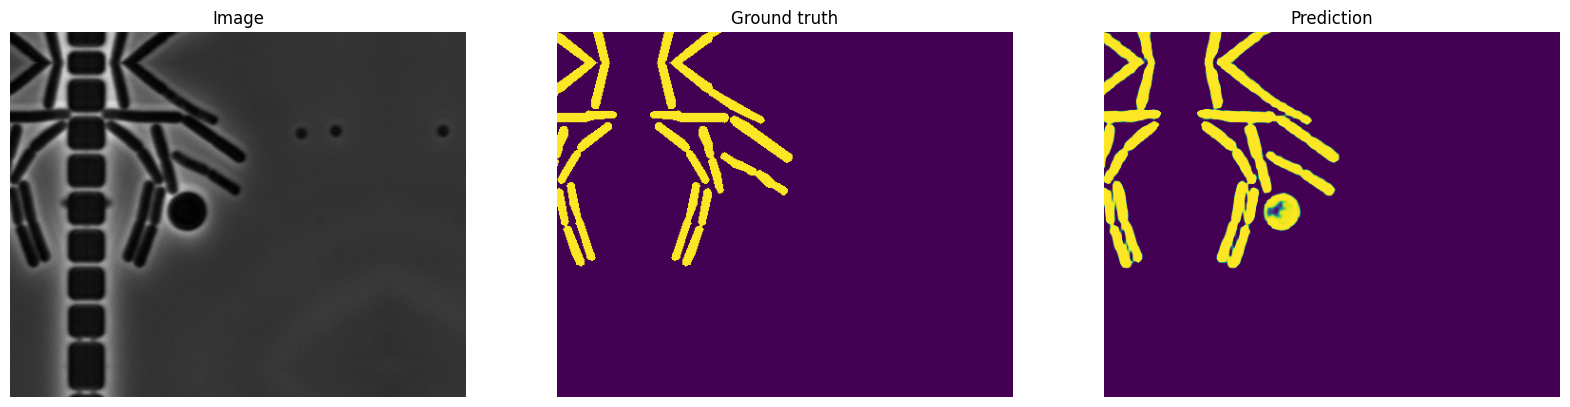

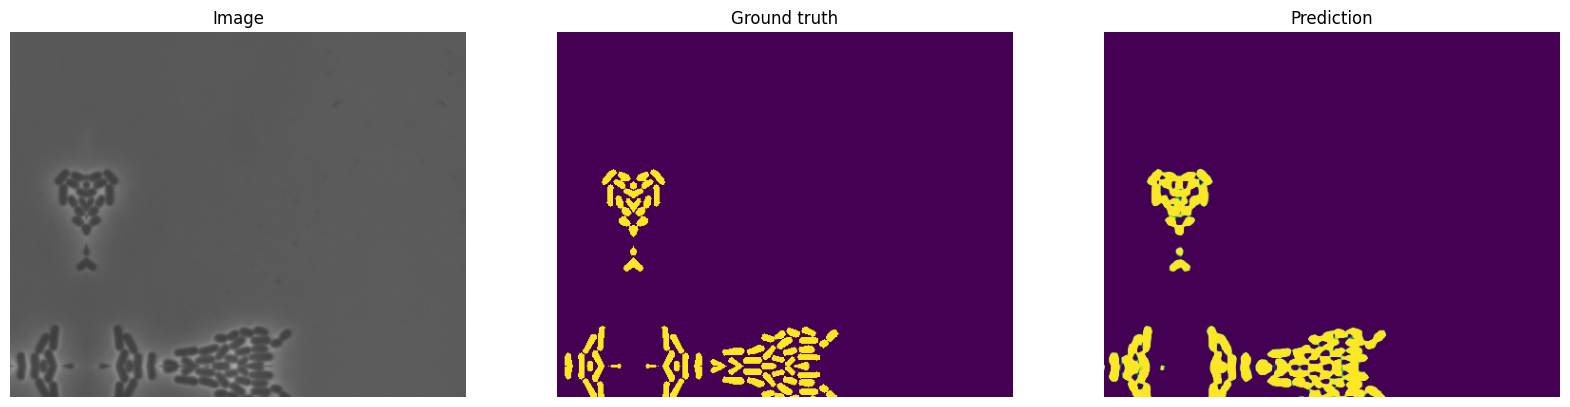

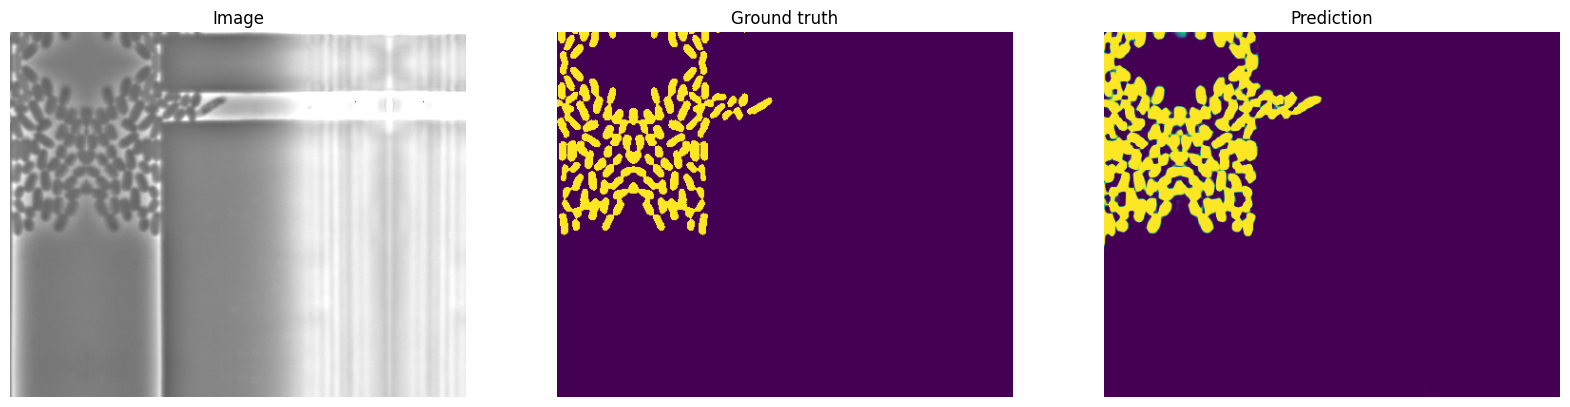

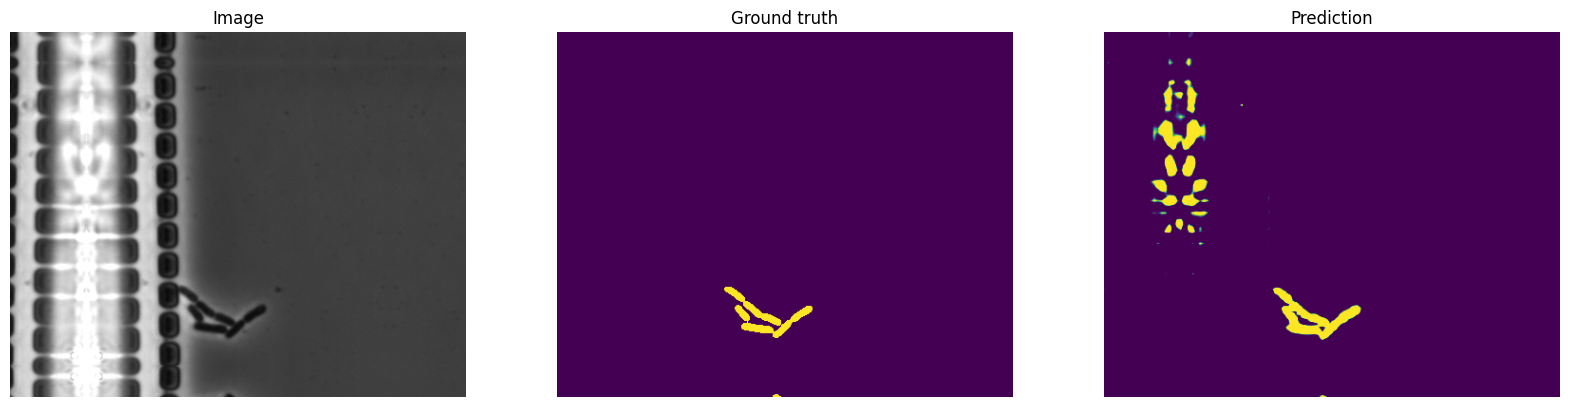

In [142]:
images, masks = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(images)
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    if idx < 4:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break

### Limitations of generalizability

(-0.5, 319.5, 319.5, -0.5)

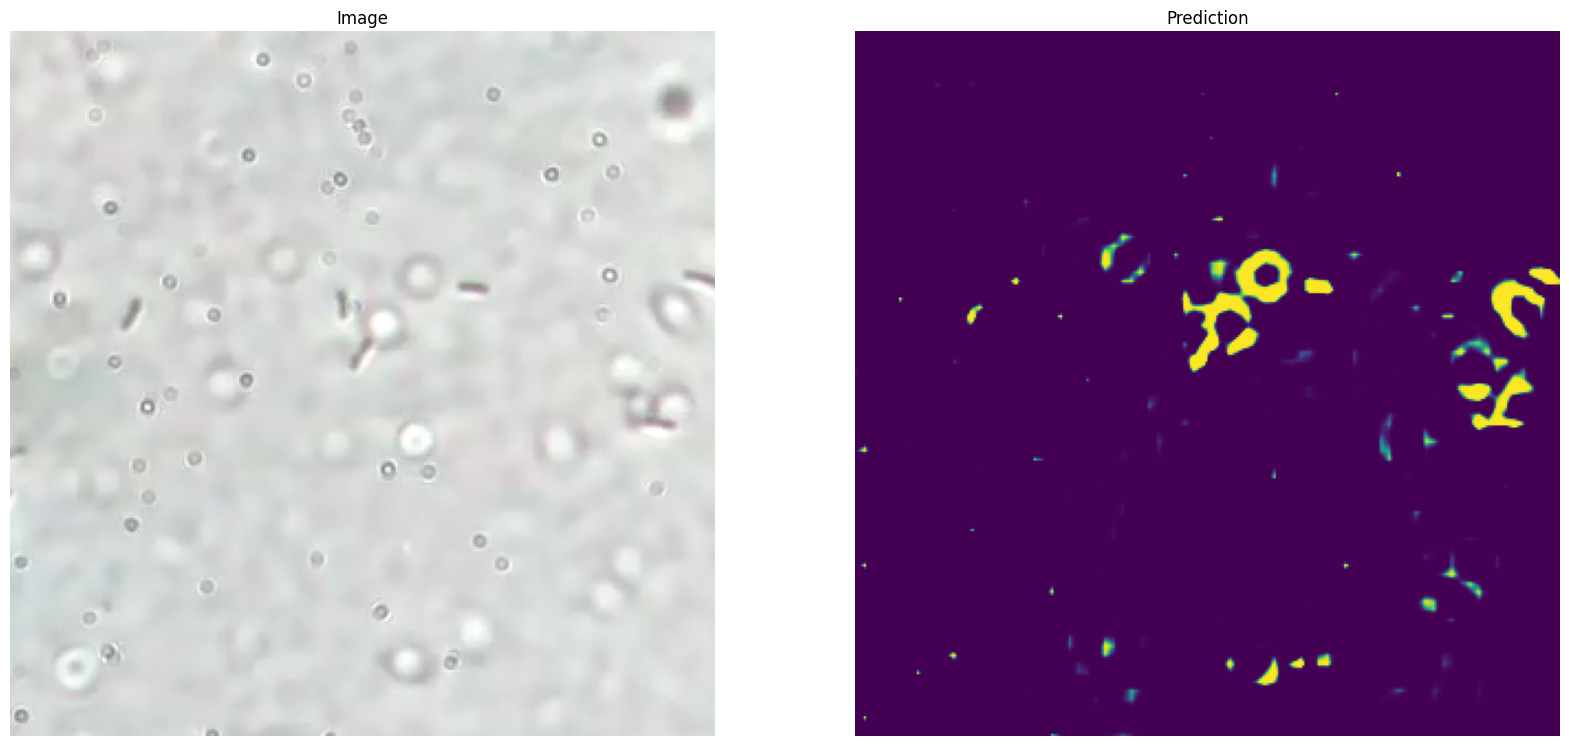

In [143]:
assert model is not None, "train model first"

image = cv2.imread("ecoli_full.png")
transformation = A.RandomCrop(height=320, width=320, always_apply=True)
image = transformation(image=image)["image"]

image = image.transpose(2, 0, 1)
with torch.no_grad():
    model.eval()
    logits = model(torch.Tensor(image))
pr_mask = logits.sigmoid()


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pr_mask.numpy().squeeze())
plt.title("Prediction")
plt.axis("off")